In [1]:
#%pip install -q keras_nlp==0.6.3 keras-core==0.1.7

In [2]:
#%pip uninstall tensorflow keras



In [3]:
#%pip install transformers


In [4]:
#%pip install wandb

In [5]:
#%pip install tensorflow==2.17.0

In [6]:
from tensorflow import keras

2024-10-16 05:10:39.489828: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 05:10:39.520666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 05:10:39.539431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 05:10:39.545039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 05:10:39.563830: I tensorflow/core/platform/cpu_feature_guar

In [7]:
from tensorflow.keras.models import Sequential

In [8]:
#%pip install tensorflow[and-cuda]

In [9]:
#%pip install tensorflow


In [10]:
#%pip install keras --upgrade

In [11]:
#%pip install jax

In [12]:
#%pip install torch

In [13]:
import os
#os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch" 
# os.environ["WANDB_SILENT"] = "false" # for wandb

import keras_nlp
import keras_core as keras
import keras_core.backend as K


import torch
# import jax
import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')


Using JAX backend.


/tmp/ipykernel_20609/3519231867.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [14]:
print("TensorFlow:", tf.__version__)
# print("JAX:", jax.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.17.0
Keras: 0.1.7
KerasNLP: 0.6.3


In [15]:
class CFG:
    verbose = 0  # Verbosity
    
    wandb = True  # Weights & Biases logging
   
    _wandb_kernel = 'awsaf49' 
   
    
    preset = "deberta_v3_base_en"  
    sequence_length = 200  
    
    device = 'TPU'  
    
    seed = 42  # Random seed
    
    num_folds = 5  # Total folds
    selected_folds = [0, 1]  # Folds to train on
    
    epochs = 3 # Training epochs
    batch_size = 3  # Batch size
    drop_remainder = True  # Drop incomplete batches
    cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM
    
    scheduler = 'cosine'  # Learning rate scheduler
    
    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

In [16]:
keras.utils.set_random_seed(CFG.seed) #so that similar result is produced

In [17]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

        # instantiate a distribution strategy
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [18]:
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on CPU


2024-10-16 05:10:44.133569: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [19]:
df=pd.read_csv("train_essays.csv")
df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


# Train Data: 1,378
# Sample:


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real


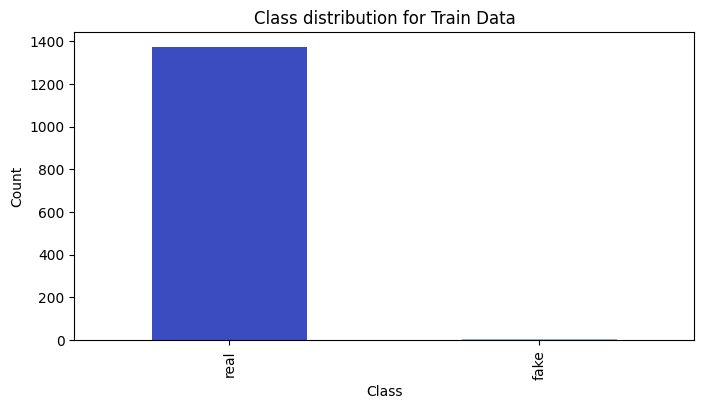

In [20]:
df['label'] = df.generated.copy()
df['name'] = df.generated.map(CFG.label2name)  # Map answer labels using name-to-label mapping

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()


# External Data: 17,263
# Sample:


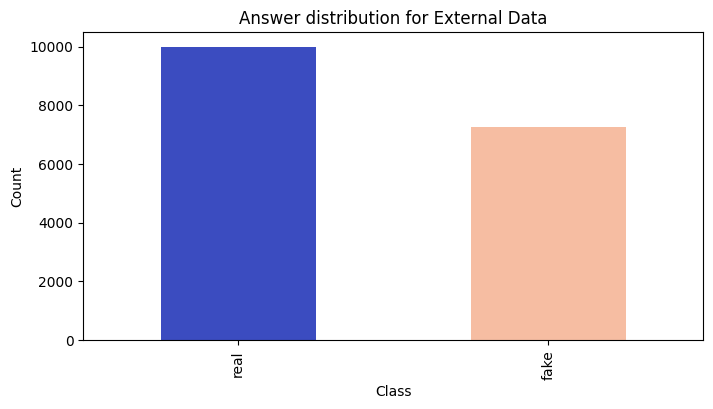

In [21]:
ext_df1 = pd.read_csv('train_drcat_01.csv')
ext_df2 = pd.read_csv('argugpt.csv')[['id','text','model']]
ext_df2.rename(columns={'model':'source'}, inplace=True)
ext_df2['label'] = 1

ext_df = pd.concat([
    ext_df1[ext_df1.source=='persuade_corpus'].sample(10000),
    ext_df1[ext_df1.source!='persuade_corpus'],
#     ext_df2,
])

# ext_real_df = ext_df[['id', 'text']].copy()
# ext_real_df['label']  = 0

# ext_fake_df = ext_df[['id', 'source_text']].copy()
# ext_fake_df.rename(columns={"source_text":"text"}, inplace=True)
# ext_fake_df['label']  = 1

# ext_df = pd.concat([ext_real_df, ext_fake_df], axis=0)
ext_df['name'] = ext_df.label.map(CFG.label2name)

# Display information about the external data
print("# External Data: {:,}".format(len(ext_df)))
print("# Sample:")
ext_df.head(2)

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
ext_df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

In [22]:
df = ext_df.copy().reset_index(drop=True) # pd.concat([ext_df, df], axis=0)
df.head()

,text,label,source,fold,name
0,Being able to know what your students are feel...,0,persuade_corpus,0,real
1,The new technology called the Facial Action Co...,0,persuade_corpus,2,real
2,The new Facial Action Coding System cannot be ...,0,persuade_corpus,3,real
3,"Is the ""Facial Action Coding System"" really go...",0,persuade_corpus,4,real
4,"Generic_Name\n\nGeneric_City\n\nMarch 12, 2020...",0,persuade_corpus,3,real


In [23]:
from sklearn.model_selection import StratifiedKFold  # Import package

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

df = df.reset_index(drop=True)  # Reset dataframe index

df['stratify'] = df.label.astype(str)+df.source.astype(str)

df["fold"] = -1  # New 'fold' column

# Assign folds using StratifiedKFold
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'])):
    df.loc[val_idx, 'fold'] = fold

# Display label distribution for each fold
df.groupby(["fold", "name", "source"]).size()

fold  name  source               
0     fake  chat_gpt_moth             484
            llama2_chat               484
            llammistral7binstruct     485
      real  persuade_corpus          2000
1     fake  chat_gpt_moth             485
            llama2_chat               484
            llammistral7binstruct     484
      real  persuade_corpus          2000
2     fake  chat_gpt_moth             484
            llama2_chat               485
            llammistral7binstruct     484
      real  persuade_corpus          2000
3     fake  chat_gpt_moth             484
            llama2_chat               484
            llammistral7binstruct     484
      real  persuade_corpus          2000
4     fake  chat_gpt_moth             484
            llama2_chat               484
            llammistral7binstruct     484
      real  persuade_corpus          2000
dtype: int64

In [24]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, 
    sequence_length=CFG.sequence_length, 
)

In [25]:
inp = preprocessor(df.text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (200,)
padding_mask : (200,)


2024-10-16 05:10:46.134477: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [26]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text 

In [27]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

In [28]:
def get_datasets(fold):
    train_df = df[df.fold!=fold].sample(frac=1)  # Get training fold data
        
    train_texts = train_df.text.tolist()  # Extract training texts
    train_labels = train_df.label.tolist()  # Extract training labels
    
    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True)

    valid_df = df[df.fold==fold].sample(frac=1)  # Get validation fold data
    valid_texts = valid_df.text.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels
    
    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False)
    
    return (train_ds, train_df), (valid_ds, valid_df)  # Return datasets and dataframes

In [29]:
import wandb  # Import wandb library for experiment tracking

try:
    
    wandb.login(key="9abbf64fcb060a5abc9535f7f8ba5cc30c7a75a7")  # Login to wandb with the API key
    anonymous = None  # Set anonymous mode to None
except:
    print("No Kaggle environment detected")
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)  # Login to wandb anonymously and relogin if needed

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anony-mouse-319812621250491530. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/soumili202/.netrc


In [30]:
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary
    config.update({"fold": int(fold)})  # Add fold to config
    print("Config:", config)  # Print config
    run = wandb.init(project="llm-fake-text",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

# Log best result for error analysis
def log_wandb():
    wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr]  # Return WandB callbacks

In [31]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

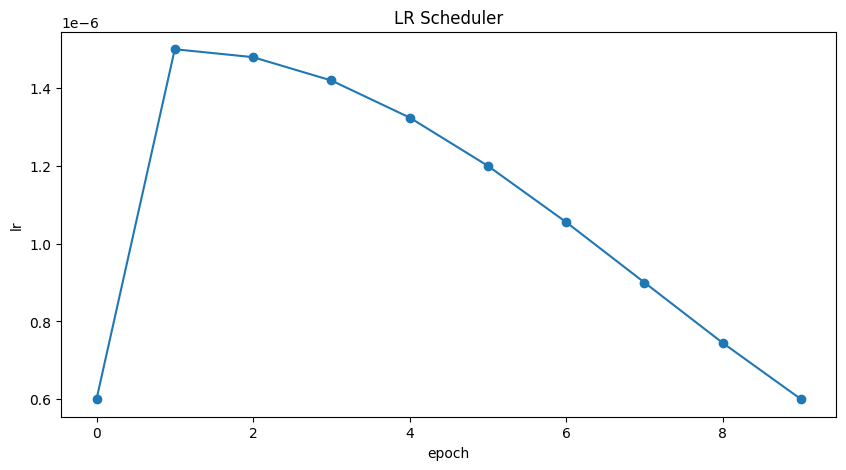

In [32]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

In [33]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)  # Get lr callback
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor='val_auc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks

    if CFG.wandb:  # If WandB is enabled
        wb_cbs = get_wb_callbacks(fold)  # Get WandB callbacks
        callbacks.extend(wb_cbs) 
        
    return callbacks  # Return the list of callbacks

In [41]:

def build_model():
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1 # one output per one option, for five options total 5 outputs
    )
    inputs = classifier.input
    logits = classifier(inputs)
        
    # Compute final output
    outputs = keras.layers.Activation("sigmoid")(logits)
    model = keras.Model(inputs, outputs)
    
    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=keras.optimizers.AdamW(5e-6),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        metrics=[
            keras.metrics.AUC(name="auc"),
        ],
        jit_compile=False
    )
    return model
    
    
    


In [42]:
model = build_model()

In [43]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 1)         │ 184,422,9… │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
keras.utils.plot_model(model, show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [48]:
for fold in CFG.selected_folds:
    # Initialize Weights and Biases if enabled
    if CFG.wandb:
        run = wandb_init(fold)

    # Get train and validation datasets
    (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)
    
    # Get callback functions for training
    callbacks = get_callbacks(fold)

    # Print training information
    print('#' * 50)
    print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
    print(f'\tNum Train: {len(train_df)} | Num Valid: {len(valid_df)}')
    print('#' * 50)
    
    # Clear TensorFlow session and build the model within the strategy scope
    K.clear_session()
    with strategy.scope():
        model = build_model()

    # Start training the model
    history = model.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        callbacks=callbacks,
        steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas),
    )
    
    # Find the epoch with the best validation accuracy
    best_epoch = np.argmax(model.history.history['val_auc'])
    best_auc = model.history.history['val_auc'][best_epoch]
    best_loss = model.history.history['val_loss'][best_epoch]

    # Print and display best results
    print(f'\n{"=" * 17} FOLD {fold} RESULTS {"=" * 17}')
    print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST AUC   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
    print('=' * 50)
    
    # Log best result on Weights and Biases (wandb) if enabled
    if CFG.wandb:
        log_wandb()  # Log results
        wandb.run.finish()  # Finish the run
#         display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard
    print("\n\n")

TypeError: Object of type getset_descriptor is not JSON serializable

In [ ]:
wandb login --relogin


SyntaxError: invalid syntax (3672671966.py, line 1)

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
